In [2]:
pip install ncps

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.5 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
#from ncps.wirings import AutoNCP
#from ncps.tf import LTC
import tensorflow as tf


def create_cnn_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),  # Convolutional layer with 32 filters and 3x3 kernel
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 64 filters and 3x3 kernel
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),  # Convolutional layer with 128 filters and 3x3 kernel
        layers.MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer
        layers.Flatten(),  # Flatten layer to convert 2D feature maps to a 1D vector
        layers.Dense(128, activation='relu'),  # Dense layer with 128 units
        layers.Dense(input_shape[0] * input_shape[1], activation='linear')  # Output layer with linear activation
    ])
    return model
# Model Definition Function
def create_lstm_model():
#height, width, channels = (78, 200, 3)

   # ncp = LTC(AutoNCP(32, output_size=8), return_sequences=True)
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=(128, 128)),  # LSTM layer with 64 units
        #BatchNormalization(),
        layers.LSTM(64, return_sequences=True),  # Second LSTM layer with 64 units
         BatchNormalization(),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Activation("linear")),
        #layers.LayerNormalization(),
        layers.Dense(128),
       # BatchNormalization()
    ])
    return model

In [4]:

def plot_accuracy(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to plot predicted vs target spectrograms
def plot_spectrograms(y_val, y_pred, sample_indices):
    for idx in sample_indices:
        plt.figure(figsize=(12, 6))

        # Display target spectrogram
        plt.subplot(1, 2, 1)
        plt.imshow(y_val[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Target Spectrogram - Sample {idx}")

        # Display predicted spectrogram
        plt.subplot(1, 2, 2)
        plt.imshow(y_pred[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Predicted Spectrogram - Sample {idx}")

        plt.tight_layout()
        plt.show()


In [15]:
from google.colab import drive
drive.mount('/content/drive')

# Scaling functions
def scaled_in(matrix_spec):
    return (matrix_spec + 46) / 50

def scaled_ou(matrix_spec):
    return (matrix_spec - 6) / 82

# Data Preparation Function
def prepare_data(path_save_spectrogram):
    X_in = np.load(os.path.join(path_save_spectrogram, 'noisy_voice_amp_db.npy'))
    X_ou = np.load(os.path.join(path_save_spectrogram, 'voice_amp_db.npy'))
    X_ou = X_in - X_ou
    X_in = scaled_in(X_in)
    X_ou = scaled_ou(X_ou)

    # Split into training and validation
    x_train, x_val, y_train, y_val = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

    # Reshape for LSTMs (128 timesteps, 128 features)
    x_train_reshaped = x_train.reshape((x_train.shape[0], 128, 128))
    x_val_reshaped = x_val.reshape((x_val.shape[0], 128, 128))
    y_train_reshaped = y_train.reshape((y_train.shape[0], 128, 128))
    y_val_reshaped = y_val.reshape((y_val.shape[0], 128, 128))

    return x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped



# Training and Evaluation Function
def train_and_evaluate_model(model, x_train, x_val, y_train, y_val):
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=563,
    decay_rate=0.9,
    staircase=True)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mse',
        metrics=['mae']
    )

    # ModelCheckpoint to save the best model
    model_checkpoint_path = 'best_model_lstm.keras'
    checkpoint = ModelCheckpoint(
        model_checkpoint_path,
        verbose=1,
        monitor='val_loss',
        save_best_only=True,
        mode='auto'
    )

    # Train the model
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        epochs=5,
        batch_size=5,
        verbose=1,
        callbacks=[checkpoint]
    )

    # Compute MSE and SNR
    y_pred = model.predict(x_val)

    # Reshape target and prediction for MSE calculation
    y_val_flat = y_val.reshape(y_val.shape[0], -1)
    y_pred_flat = y_pred.reshape(y_pred.shape[0], -1)

    # Compute MSE
    mse = mean_squared_error(y_val_flat, y_pred_flat)
    print(f"Mean Squared Error (MSE): {mse}")

    # Compute SNR
    def compute_snr(target, prediction):
        noise = target - prediction
        snr = 10 * np.log10(np.mean(target**2) / np.mean(noise**2))
        return snr

    snr = compute_snr(y_val_flat, y_pred_flat)
    print(f"Signal-to-Noise Ratio (SNR): {snr} dB")

    # Plot training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plot_accuracy(history)

    # Plot predicted vs target spectrograms
    sample_indices = [89]
    y_pred = model.predict(x_val)
    plot_spectrograms(y_val, y_pred,sample_indices)


    return history



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/5
180/180 [==============================] - ETA: 0s - loss: 0.0302 - mae: 0.1012
Epoch 1: val_loss improved from inf to 0.01490, saving model to best_model_lstm.keras
180/180 [==============================] - 21s 89ms/step - loss: 0.0302 - mae: 0.1012 - val_loss: 0.0149 - val_mae: 0.0886
Epoch 2/5
180/180 [==============================] - ETA: 0s - loss: 0.0119 - mae: 0.0789
Epoch 2: val_loss improved from 0.01490 to 0.01424, saving model to best_model_lstm.keras
180/180 [==============================] - 15s 83ms/step - loss: 0.0119 - mae: 0.0789 - val_loss: 0.0142 - val_mae: 0.0847
Epoch 3/5
180/180 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.0781
Epoch 3: val_loss improved from 0.01424 to 0.01345, saving model to best_model_lstm.keras
180/180 [==============================] - 15s 82ms/step - loss: 0.0116 - mae: 0.0781 - val_loss: 0.0135 - val_mae: 0.0840
Epoch 4/5
180/180 [==============================] - ETA: 0s - loss: 0.0111 - mae: 0.0767
Epoch

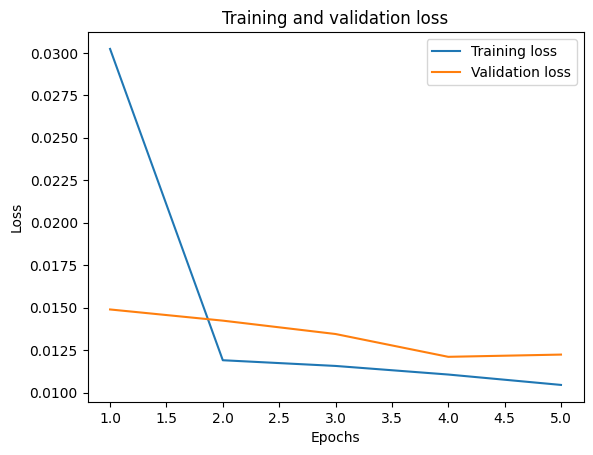

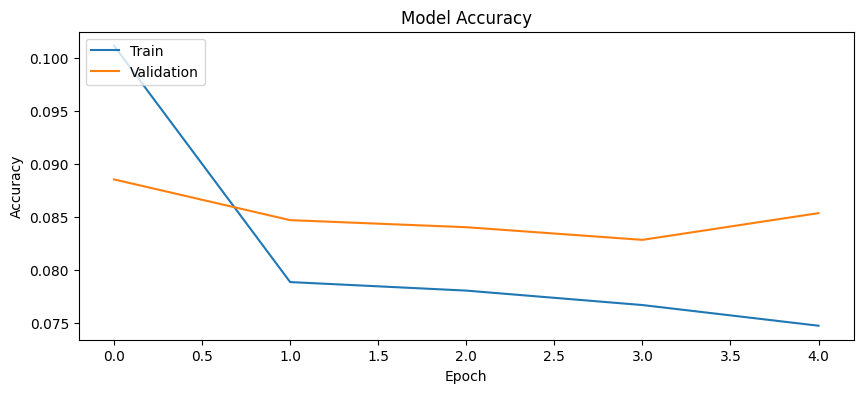

4/4 [==============================] - 0s 55ms/step


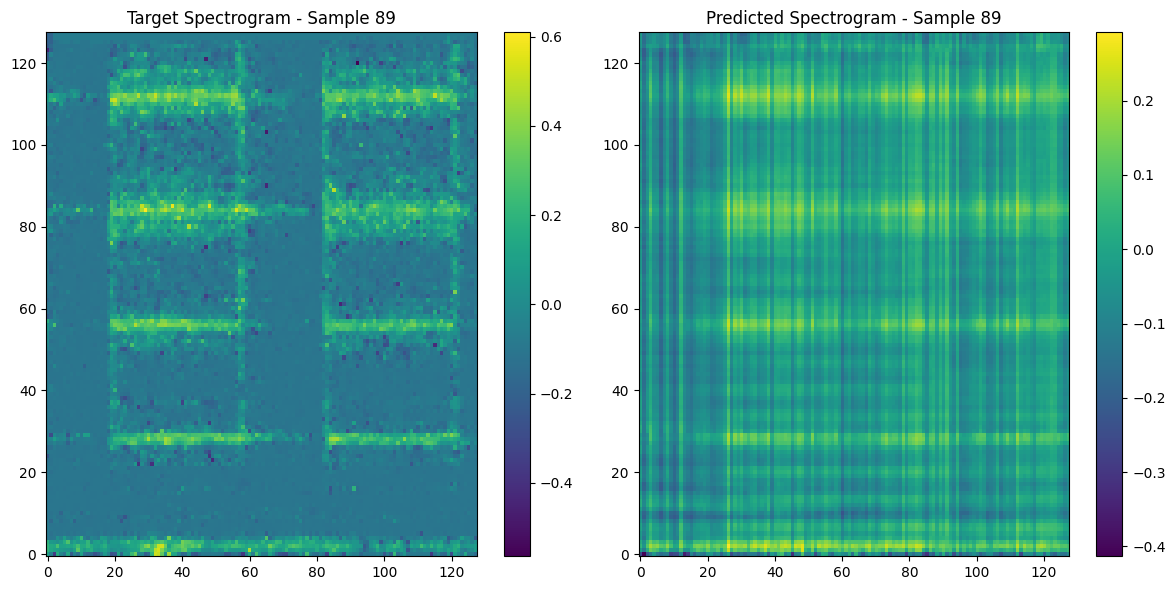

In [16]:

# Main Workflow
def main():
    # Data Preparation
    path_save_spectrogram = '/content/drive/MyDrive/npy/New1000/'
    x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped = prepare_data(path_save_spectrogram)
    input_shape=(128, 128);
    # Create the model
    lstm_model = create_lstm_model()

    # Train and evaluate the model
    train_and_evaluate_model(lstm_model, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped)

    # Save the model architecture and weights
    model_json = lstm_model.to_json()
    with open('model_lstm.json', 'w') as json_file:
        json_file.write(model_json)

    lstm_model.save_weights('model_lstm_weights.keras')


# Run the main function
if __name__ == "__main__":
    main()

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt

import os
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrograms_from_yval(y_val, save_dir):
    num_samples = len(y_val)  # Get the number of spectrograms

    # Create save directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    for idx in range(num_samples):
        plt.figure(figsize=(8, 6))

        # Display target spectrogram
        plt.imshow(y_val[idx], cmap='viridis', origin='lower', aspect='auto')
        plt.colorbar()
        plt.title(f"Spectrogram - Sample {idx}")
        plt.xlabel('Time')
        plt.ylabel('Frequency')

        plt.tight_layout()

        # Save the figure
        save_path = os.path.join(save_dir, f'spectrogram_{idx}.png')
        plt.savefig(save_path)
        plt.close()  # Close the figure to release memory

# Example usage:
# Replace 'your_y_val' with your actual array of spectrograms

path_save_spectrogram = '/content/drive/MyDrive/npy/New1000/'
x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped = prepare_data(path_save_spectrogram)
save_dir = '/content/drive/MyDrive/spectro2'  # Directory where spectrogram images will be saved

plot_spectrograms_from_yval(y_val_reshaped, save_dir)